In [1]:
from jaxtyping import Float
from torch import Tensor
from torch.utils.tensorboard import SummaryWriter
from spikingjelly.activation_based.neuron import BaseNode

import torch, wandb
import numpy as np
import matplotlib.pyplot as plt

from utils.model import L2Net, AbstractL2Net
from utils.load import load_l2net_model, load_abst_l2net_model

In [ ]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# torch.autograd.set_detect_anomaly(True)
writer = SummaryWriter(log_dir="./runs/l2_distance_experiment")

np.random.seed(42)
rng = torch.manual_seed(42)

In [3]:
torch.set_printoptions(threshold=10_000, precision=2, linewidth=160, sci_mode=False)

In [ ]:
cfg = dict(
    NUM_SAMPLES = 100000,
    NUM_EPOCHS = 100,
    VECTOR_DIM = 64,
    MIN_VAL = -7.,
    MAX_VAL = 7.,
    TIME_STEPS = 40,
    JEFFRESS_COMPRESSION = 1,
    BATCH_SIZE = 512,
    INITIAL_ALPHA = 2,
    MAX_ALPHA = 10.0,
    LR = 3e-2,
    EVAL_MODE = False,
)

In [5]:
NUM_SAMPLES = int(cfg["NUM_SAMPLES"])  # 총 1000 개의 샘플 생성
NUM_EPOCHS = int(cfg["NUM_EPOCHS"])
VECTOR_DIM = int(cfg["VECTOR_DIM"])      # 각 벡터는 3차원
MIN_VAL = cfg["MIN_VAL"]
MAX_VAL = cfg["MAX_VAL"]
TIME_STEPS = int(cfg["TIME_STEPS"])  # 각 레이어 당 17 타임스텝
JEFFRESS_COMPRESSION = int(cfg["JEFFRESS_COMPRESSION"])
BATCH_SIZE = int(cfg["BATCH_SIZE"])
INITIAL_ALPHA = float(cfg["INITIAL_ALPHA"])
MAX_ALPHA = float(cfg["MAX_ALPHA"])
LR = float(cfg["LR"])
EVAL_MODE = bool(cfg["EVAL_MODE"])

In [6]:
# model = L2Net(TIME_STEPS,
#               VECTOR_DIM,
#               jeffress_radius=TIME_STEPS-1,
#               jeffress_compression=JEFFRESS_COMPRESSION,
#               temporal_min=MIN_VAL,
#               temporal_max=MAX_VAL,
#               accelerated=False).to(device)

model = AbstractL2Net(TIME_STEPS,
              jeffress_radius=TIME_STEPS-1,
              jeffress_compression=JEFFRESS_COMPRESSION).to(device)
model

AbstractL2Net()

In [ ]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from utils.datasets import generate_l2_square_dataset, encode_temporal_np

X_data, y_data = generate_l2_square_dataset(NUM_SAMPLES, VECTOR_DIM, low=MIN_VAL, high=MAX_VAL, normalize=True)  # X_data: N 2 D, y_data: N
# X_data_temporal = torch.stack([torch.FloatTensor(encode_temporal_np(X_data[:,0,:], TIME_STEPS, 0, min_val=MIN_VAL, max_val=MAX_VAL)),
#                       torch.FloatTensor(encode_temporal_np(X_data[:,1,:], TIME_STEPS, 0, min_val=MIN_VAL, max_val=MAX_VAL))],
X_data = (torch.FloatTensor(X_data) - MIN_VAL) / (MAX_VAL - MIN_VAL)  # N 2 D
y_data = torch.FloatTensor(y_data) # N D
# dataset = torch.utils.data.TensorDataset(X_data_temporal.transpose(1, 0), y_data, torch.tensor(X_data))  # T N 2D -> N T 2D
dataset = torch.utils.data.TensorDataset(X_data, y_data, torch.tensor(X_data))  # N 2D
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
    )
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
current_alpha = INITIAL_ALPHA
loss = torch.tensor(float("inf"))

pred_hist, target_hist, err_hist = [], [], []
train_step = 0
eval_step = 0
substep = 0
eval_substep = 0
if not EVAL_MODE:
    with wandb.init(project="DelayedTemporal",
                    config=cfg) as run:
        run.define_metric("train/*", step_metric="train_step")
        run.define_metric("delay/*", step_metric="train_step")
        run.define_metric("SDC/*", step_metric="train_step")
        run.define_metric("Neuron/*", step_metric="substep")
        run.define_metric("eval/*", step_metric="eval_step")
        run.define_metric("eval_sub/*", step_metric="eval_substep")
        for epoch in tqdm(range(NUM_EPOCHS)):
            model.train()
            
            # current_alpha = INITIAL_ALPHA + (MAX_ALPHA - INITIAL_ALPHA) * epoch / NUM_EPOCHS
            # for m in model.modules():
            #     if isinstance(m, BaseNode):
            #         if hasattr(m.surrogate_function, "alpha"):
            #             setattr(m.surrogate_function, "alpha", min(current_alpha, 10.0))
                        
            for i, batch in enumerate(pbar:=tqdm(train_loader, leave=False)):
                # inputs:Float[Tensor, "N T 2 D"]; targets:Float[Tensor, "N D"]
                inputs:Float[Tensor, "N 2 D"]; targets:Float[Tensor, "N D"]
                inputs, targets, input_raw = batch
                inputs = inputs.to(device); targets = targets.to(device); input_raw = input_raw.to(device)
                # out = model(inputs.transpose(1, 0)) # N T 2 D -> T N 2 D -> model -> T N 1
                out = model(inputs) # N 2 D -> model -> N 1
                pred = out
                loss = criterion(pred, targets)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                pbar.set_postfix({"loss": loss.item(), "scale":(out.max()-out.min()).item(), "lr": scheduler.get_last_lr()[0]})
                if i % 10 == 0:
                    run.log({
                        "train_step": (train_step := train_step + 1),
                        "train/loss": loss.item(),
                        "train/err":(pred - targets).abs().mean().item(),
                        "train/alpha": current_alpha,
                    # }|{
                    #         f"SDC/rate_{i}": torch.stack(model.stats['jeffress_model.2.neuron'], dim=0).mean(dim=(0,1,2))[i] for i in range(2*TIME_STEPS - 1)
                            }
                    )
                    # for t in range(2*TIME_STEPS):
                    #     run.log({
                    #         "substep": (substep := substep + 1),
                    #     }
                    #             |{
                    #         f"Neuron/I_{j}": model.jeffress_model[2].i_seq[t][0,0,j] for j in range(2*TIME_STEPS - 1)
                    #         }
                    #             |{
                    #         f"Neuron/V_{j}": model.jeffress_model[2].v_seq[t][0,0,j] for j in range(2*TIME_STEPS - 1)
                    #         })
            scheduler.step()
            
            with torch.no_grad():
                model.eval()
                for batch in (pbar:=tqdm(test_loader, leave=False)):
                    inputs, targets, input_raw = batch
                    inputs = inputs.to(device); targets = targets.to(device); input_raw = input_raw.to(device)
                    # out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N  
                    out = model(inputs) # N 2 D -> model -> N 1
                    pred = out
                    loss = criterion(pred, targets)
                    pred_hist.extend(pred.squeeze().tolist())
                    target_hist.extend(targets.squeeze().tolist())
                    err_hist.extend(torch.abs(pred.squeeze() - targets.squeeze()).tolist())
                    pbar.set_postfix({"loss": loss.item(), "pred": pred_hist[-1], "target": target_hist[-1]})
                    
                    run.log({"eval_step": (eval_step := eval_step + 1),
                            "eval/loss": loss.item()})
                    for n in range(pred.shape[0]):
                        run.log({"eval_substep": (eval_substep := eval_substep + 1),
                            "eval_sub/err":  (pred.squeeze() - targets.squeeze()).abs()[n].item()})
else:
    hex = "5836d6be043f11f19a160242ac11000f"
    model, cfg = load_abst_l2net_model(hex, torch.device("cuda"))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs, targets, input_raw = batch
            inputs = inputs.to(device); targets = targets.to(device); input_raw = input_raw.to(device)
            # out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N
            out = model(inputs) # N 2 D -> model -> N 1
            pred = out
            loss = criterion(pred, targets)
            pred_hist.extend(pred.view(-1).tolist())
            target_hist.extend(targets.view(-1).tolist())
            err_hist.extend(torch.abs(pred.view(-1) - targets.view(-1)).tolist())
    print(f"Test MSE Loss: {loss.item():.6f}, MAE: {np.mean(err_hist):.6f}")

/tmp/ipykernel_376164/1295619725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.utils.data.TensorDataset(X_data, y_data, torch.tensor(X_data))  # N 2D


AbstractL2Net loaded with following configuration:
{'NUM_SAMPLES': 100000, 'NUM_EPOCHS': 100, 'VECTOR_DIM': 64, 'MIN_VAL': -6.0, 'MAX_VAL': 6.0, 'TIME_STEPS': 21, 'JEFFRESS_COMPRESSION': 1, 'BATCH_SIZE': 512, 'INITIAL_ALPHA': 2, 'MAX_ALPHA': 10.0, 'LR': 0.03, 'EVAL_MODE': False}


  0%|          | 0/40 [00:00<?, ?it/s]

Test MSE Loss: 0.012038, MAE: 0.106594


In [8]:
if not EVAL_MODE:
    from uuid import uuid1
    from json import load, dump
    from pathlib import Path

    save_id = uuid1().hex
    save_dir = Path(f"models/{save_id}")

    if not save_dir.exists():
        save_dir.mkdir(parents=True, exist_ok=True)

    with open("models/contents.json", "r", encoding="utf-8") as f:
        contents = load(f)

    contents |= ({save_id: {
        "model": model.__class__.__name__,
        "final_loss": loss.item(),
        "final_mae": np.mean(err_hist)} | cfg})

    with open("models/contents.json", "w", encoding="utf-8") as f:
        dump(contents, f, indent=4)

    torch.save(model.state_dict(), save_dir / "model.pt")
    torch.save(cfg, save_dir / "model.cfg")
    print(f"Model saved to {save_dir}/model.pt")

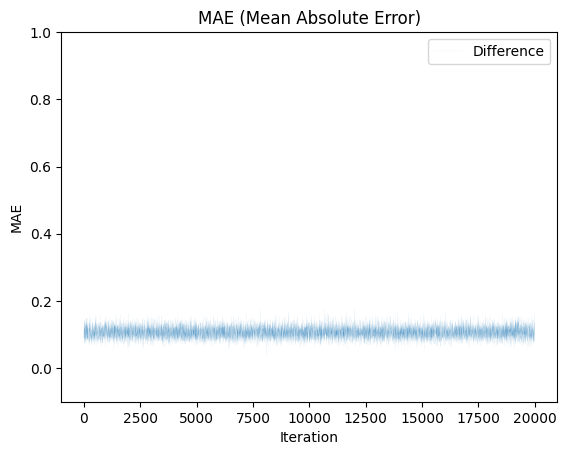

In [9]:
plt.title("MAE (Mean Absolute Error)")
plt.plot(err_hist, linewidth=0.025, label="Difference")
plt.ylim(-.1, 1)
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.legend()

In [10]:
# y_data

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

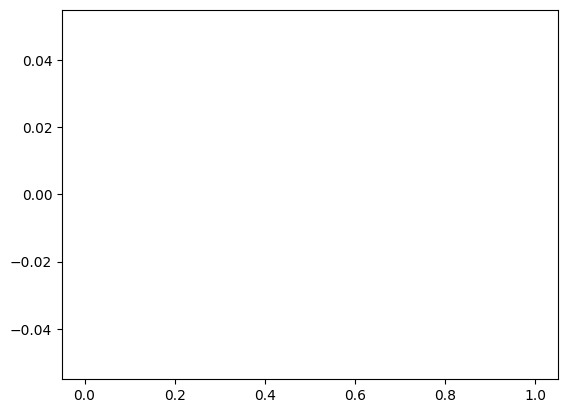

In [11]:
plt.hist(err_hist[100000:])